In [ ]:
import re
from tqdm import tqdm
import emoji
import pandas as pd

In [2]:
# expect df type(text, label)
class data_preprocessing():
    def __init__(self, text_col, label_col, target_df, token_list):
        self.target_df = target_df
        self.text_col = text_col
        self.label_col = label_col
        self.token_list = token_list
    
    def remove_special_token(self,df_temp):           
        target_column_name = self.text_col
        special_token = self.token_list
        if len(special_token) > 0:
            for token in special_token:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(token, " "))
        return df_temp

    def eliminate_url(self,df_temp):

        target_column_name = self.text_col
        text = df_temp[target_column_name]
        for i in tqdm(text):
            urls = re.findall(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', i)
            for i in urls:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def eliminate_username(self,df_temp):

        target_column_name = self.text_col
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'@\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
     
    def eliminate_hashtag(self,df_temp):

        target_column_name = self.text_col
        for i in tqdm(df_temp[target_column_name]):
            user_name = re.findall(r'#\w*', i)
            for i in user_name:
                df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ""))
        return df_temp
    
    def convert_abbreviation(self,df_temp):

        target_column_name = self.text_col
        am = "'m"
        are = "'re"
        have = "'ve"
        not_ = "n't"
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(am, " am"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(are, "  are"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(have, " have"))
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(not_, " not"))
        return df_temp
        
    def final_check(self,df_temp):

        target_column_name = self.text_col
        df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x:re.sub(r'[^A-Za-z0-9 ]+', ' ', x).lower())
        return df_temp
            
    def eliminate_symbol(self,df_temp):

        target_column_name = self.text_col
        symbol_list = [',',"'",'!','@','$','%','^','&','*','(',')','-','+','?','>','<','=','.',':',';','  ','  ','   ','    ','      ','      ','  ']
        for i in tqdm(symbol_list):
            df_temp[target_column_name] = df_temp[target_column_name].apply(lambda x: x.replace(i, ' '))
        return df_temp
    
    def label_clean(self,df_temp):
        labels = self.label_col
        df_temp[labels] = df_temp[labels].astype(int)
        return df_temp
        
    def process_all(self):
        df_temp = self.target_df
        target_column_name = self.text_col
        labels = self.label_col
        df_remove_token = self.remove_special_token(df_temp)
        df_fresh = self.convert_abbreviation(df_remove_token)
        df_remove_url = self.eliminate_url(df_fresh)
        df_eliminate_hashtag = self.eliminate_hashtag(df_remove_token)
        df_remove_username = self.eliminate_username(df_eliminate_hashtag)
        df_remove_symbol = self.eliminate_symbol(df_remove_username)
        df_final_check = self.final_check(df_remove_url)
        df_label = self.label_clean(df_final_check)
        print("finished!!")
        return df_label

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_df(text, label):
    temp_dic = {'Text':text,'label':label}
    temp_df = pd.DataFrame(temp_dic)
    return temp_df
    
def split_dataset(target_df, split_col, text_col, label_col, train_ratio, test_ratio):
    all_type = np.unique(target_df[split_col])
    all_df = []
    if len(all_type) != 0:
        for types in all_type:
            all_df.append(target_df[target_df[split_col] == types])
        length_check = [len(i) for i in all_df]
        train_df = all_df[length_check.index(max(length_check))]
        to_exclude = {length_check.index(max(length_check))}
        if 'test' in all_type:
            test_df = target_df[target_df[split_col] == 'test']
            to_exclude.add(length_check.index(len(test_df)))
            final_length = [element for i, element in enumerate(length_check) if i not in to_exclude]
            val_df = all_df[final_length.index(final_length[0])]
        else:
            final_length = [element for i, element in enumerate(length_check) if i not in to_exclude]
            val_df = all_df[length_check.index(length_check[0])]
            test_df = all_df[length_check.index(length_check[1])]
    else:
        X = target_df[text_col]
        y = target_df[label_col]
        test_size = 1-train_ratio
        temp_ratio = test_ratio/test_size
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size , random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=temp_ratio, random_state=42)
        train_df = generate_df(X_train, y_train)
        test_df = generate_df(X_test, y_test)
        val_df = generate_df(X_val, y_test)
    return train_df, val_df, test_df

# Initiate your parameters Notice:sample test 

In [4]:
import pandas as pd
comments = pd.read_csv('attack_annotated_comments.tsv',sep='\t',encoding = "ISO-8859-1")
annotation = pd.read_csv('attack_annotations.tsv',sep='\t',encoding = "ISO-8859-1")
worker = pd.read_csv('attack_worker_demographics.tsv',sep='\t',encoding = "ISO-8859-1")

In [5]:
result = pd.merge(comments, annotation, how='left', on=['rev_id'])

In [6]:
new_label = result.groupby('rev_id')['attack'].mean() > 0.5

In [ ]:
result = result.drop_duplicates(subset=['rev_id'])

In [7]:
label_list = []
for i in new_label:
    if i is True:
        label_list.append(1.0)
    else:
        label_list.append(0.0)

In [8]:
result['comment'] = result['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
result['comment'] = result['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [9]:
target_df = result
split_col = 'split'
text_col = 'comment'
label_col = 'attack'
train_ratio = 0.8
test_ratio = 0.1
token_list = ["NEWLINE_TOKEN", "TAB_TOKEN"]

In [10]:
data_processor = data_preprocessing(text_col, label_col, target_df, token_list)
target_df = data_processor.process_all()

100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [00:17<00:00,  1.57it/s]


finished!!


In [36]:
target_df = target_df.drop_duplicates(subset=['rev_id'])

In [37]:
target_df.head()

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,this is not creative those are the diction...,2002,False,article,random,train,1362,0.0,0.0,0.0,0.0,0
10,44816,the term standard model is itself less npo...,2002,False,article,random,train,1158,0.0,0.0,0.0,0.0,0
19,49851,true or false the situation as of march 2002 ...,2002,False,article,random,train,447,0.0,0.0,0.0,0.0,0
29,89320,next maybe you could work on being less conde...,2002,True,article,random,dev,3307,0.0,0.0,0.0,0.0,0
38,93890,this page will need disambiguation,2002,True,article,random,train,1369,0.0,0.0,0.0,0.0,0


In [38]:
Train_df, val_df, test_df = split_dataset(target_df, split_col, text_col, label_col, train_ratio, test_ratio)

In [57]:
target_df.to_csv('Data/AC_all.csv',index=False,header=True)

In [39]:
Train_df = Train_df[[text_col,label_col]]
val_df = val_df[[text_col,label_col]]
test_df = test_df[[text_col,label_col]]

In [40]:
Train_df.head()

,comment,attack
0,this is not creative those are the diction...,0
10,the term standard model is itself less npo...,0
19,true or false the situation as of march 2002 ...,0
38,this page will need disambiguation,0
47,important note for all sysops there is a bug ...,0


In [41]:
Train_df.to_csv('Data/Train_comment.csv',index=False,header=True)
val_df.to_csv('Data/Val_comment.csv',index=False,header=True)
test_df.to_csv('Data/Test_comment.csv',index=False,header=True)

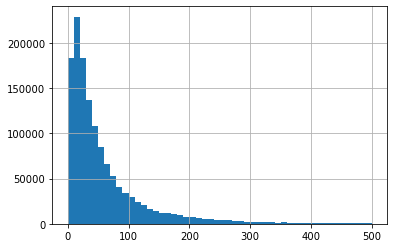

In [33]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in result[text_col]]
pd.Series(seq_len).hist(bins = 50,range=[0,500])

In [1]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
import transformers
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
source_folder = 'Data'
destination_folder = 'Model'

# Data embedding

In [4]:
def dataset_embedding(choice, MAX_SEQ_LEN, batch_size, text_col, label_col, train_doc, val_doc, test_doc):
    if choice == 'bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    else:
        tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
    label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
    text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                       fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
    fields = [(text_col, text_field),(label_col, label_field)]

    # TabularDataset
    train, valid, test = TabularDataset.splits(path=source_folder, train=train_doc, validation=val_doc,
                                               test=test_doc, format='CSV', fields=fields, skip_header=True)
    
    train_iter = BucketIterator(train, batch_size=batch_size, sort_key=lambda x: len(x.hate),
                                device=device, train=True, sort=True, sort_within_batch=True)
    valid_iter = BucketIterator(valid, batch_size=batch_size, sort_key=lambda x: len(x.hate),
                                device=device, train=True, sort=True, sort_within_batch=True)
    test_iter = Iterator(test, batch_size=batch_size, device=device, train=False, shuffle=False, sort=False)
    return train_iter, valid_iter, test_iter, tokenizer

In [5]:
split_col = 'split'
text_col = 'text'
label_col = 'hate'
train_ratio = 0.8
test_ratio = 0.1
token_list = ["NEWLINE_TOKEN", "TAB_TOKEN"]

In [6]:
# choice('roberta' ,'bert')
choice = 'roberta'
max_seq_len = 128
batch_size = 16
train_doc = 'GAB_train.csv'
val_doc = 'GAB_val.csv'
test_doc = 'GAB_test.csv'
train_iter, valid_iter, test_iter,tokenizer = dataset_embedding(choice, max_seq_len, batch_size, text_col, label_col, train_doc, val_doc, test_doc)

# Model

In [12]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        return loss, text_fea

In [22]:
model

ROBERTAClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
model

BERT(
  (encoder): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
    

In [7]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

In [8]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [9]:
def pretrain(model, optimizer, 
             train_iter, 
             valid_iter,
             model_name,
             scheduler,
             num_epochs,BATCH_SIZE):
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
    if model_name == 'roberta':
        # Pretrain linear layers, do not train bert
        for param in model.roberta.parameters():
            param.requires_grad = False
    else:
        for param in model.encoder.parameters():
            param.requires_grad = False
    model.train()
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0
    valid_period = len(train_iter)
    scheduler = None
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
        
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            target = torch.tensor(target, dtype=torch.long, device=device)
            loss = torch.nn.CrossEntropyLoss()(y_pred, target).cuda()
            print('batch_no [{}/{}]:'.format(count, int(len(train_iter))),'training_loss:',loss)
            count+=1
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        target = torch.tensor(target, dtype=torch.long, device=device)
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target).cuda()
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [10]:
# Training Function
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler,
          num_epochs,
          output_path,BATCH_SIZE):
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
    # Initialize losses and loss histories
    valid_period = len(train_iter)
    train_loss = 0.0
    scheduler = None,
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            target = torch.tensor(target, dtype=torch.long, device=device)
            loss = torch.nn.CrossEntropyLoss()(y_pred, target).cuda()
            #loss = output[0]
            print('batch_no [{}/{}]:'.format(count, int(len(train_iter)),'training_loss:',loss))
            count+=1
            loss.backward()
            
            
            # Optimizer and scheduler step
            optimizer.step()    
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        target = torch.tensor(target, dtype=torch.long, device=device)
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target).cuda()
                
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [14]:
# Main training loop
NUM_EPOCHS = 2

steps_per_epoch = len(train_iter)
model_name = 'roberta'
if model_name == 'roberta':
    model = ROBERTAClassifier(0.4)
    model = model.to(device)
else:
    model = BERT()
    model = model.to(device)

print("======================= Start pretraining ==============================")

optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)
pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS,
        model_name = model_name,BATCH_SIZE=batch_size)

======================= Start pretraining ==============================
batch_no [0/1384]: training_loss: tensor(1.0930, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1/1384]: training_loss: tensor(0.9870, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2/1384]: training_loss: tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3/1384]: training_loss: tensor(0.9170, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4/1384]: training_loss: tensor(1.0881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [5/1384]: training_loss: tensor(1.0249, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [6/1384]: training_loss: tensor(1.0355, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [7/1384]: training_loss: tensor(0.9885, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [8/1384]: training_loss: tensor(0.9954, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [9/1384]: training_loss: tensor(1.0009, device='cuda:0', grad_fn=<NllLossBackward

batch_no [88/1384]: training_loss: tensor(0.9659, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [89/1384]: training_loss: tensor(0.8895, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [90/1384]: training_loss: tensor(0.8669, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [91/1384]: training_loss: tensor(1.1408, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [92/1384]: training_loss: tensor(0.9730, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [93/1384]: training_loss: tensor(0.9729, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [94/1384]: training_loss: tensor(1.1334, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [95/1384]: training_loss: tensor(0.9329, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [96/1384]: training_loss: tensor(0.9988, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [97/1384]: training_loss: tensor(0.8875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [98/1384]: training_loss: tensor(0.9948, device='cu

batch_no [175/1384]: training_loss: tensor(0.8813, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [176/1384]: training_loss: tensor(1.0190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [177/1384]: training_loss: tensor(0.9900, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [178/1384]: training_loss: tensor(1.1081, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [179/1384]: training_loss: tensor(0.8770, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [180/1384]: training_loss: tensor(0.9312, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [181/1384]: training_loss: tensor(0.9163, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [182/1384]: training_loss: tensor(0.9530, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [183/1384]: training_loss: tensor(0.9109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [184/1384]: training_loss: tensor(0.9924, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [185/1384]: training_loss: tensor(1.0194,

batch_no [262/1384]: training_loss: tensor(1.0157, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [263/1384]: training_loss: tensor(0.9652, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [264/1384]: training_loss: tensor(1.1070, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [265/1384]: training_loss: tensor(1.0037, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [266/1384]: training_loss: tensor(0.9246, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [267/1384]: training_loss: tensor(0.9185, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [268/1384]: training_loss: tensor(0.9303, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [269/1384]: training_loss: tensor(0.9356, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [270/1384]: training_loss: tensor(0.8932, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [271/1384]: training_loss: tensor(1.1951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [272/1384]: training_loss: tensor(0.9813,

batch_no [435/1384]: training_loss: tensor(0.9454, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [436/1384]: training_loss: tensor(1.0826, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [437/1384]: training_loss: tensor(0.9883, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [438/1384]: training_loss: tensor(0.9211, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [439/1384]: training_loss: tensor(0.8980, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [440/1384]: training_loss: tensor(0.9239, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [441/1384]: training_loss: tensor(0.8718, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [442/1384]: training_loss: tensor(0.9112, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [443/1384]: training_loss: tensor(0.9210, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [444/1384]: training_loss: tensor(0.9761, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [445/1384]: training_loss: tensor(1.1361,

batch_no [522/1384]: training_loss: tensor(0.9365, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [523/1384]: training_loss: tensor(0.9680, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [524/1384]: training_loss: tensor(0.9366, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [525/1384]: training_loss: tensor(0.9100, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [526/1384]: training_loss: tensor(1.1391, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [527/1384]: training_loss: tensor(0.9261, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [528/1384]: training_loss: tensor(0.8064, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [529/1384]: training_loss: tensor(0.9189, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [530/1384]: training_loss: tensor(1.0408, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [531/1384]: training_loss: tensor(0.9941, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [532/1384]: training_loss: tensor(1.1600,

batch_no [609/1384]: training_loss: tensor(1.0033, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [610/1384]: training_loss: tensor(0.9992, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [611/1384]: training_loss: tensor(0.9502, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [612/1384]: training_loss: tensor(1.0452, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [613/1384]: training_loss: tensor(0.9348, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [614/1384]: training_loss: tensor(0.8416, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [615/1384]: training_loss: tensor(1.0369, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [616/1384]: training_loss: tensor(0.7481, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [617/1384]: training_loss: tensor(0.9476, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [618/1384]: training_loss: tensor(0.8174, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [619/1384]: training_loss: tensor(0.8585,

batch_no [697/1384]: training_loss: tensor(0.9723, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [698/1384]: training_loss: tensor(0.8675, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [699/1384]: training_loss: tensor(0.9198, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [700/1384]: training_loss: tensor(0.9288, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [701/1384]: training_loss: tensor(0.8833, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [702/1384]: training_loss: tensor(1.0163, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [703/1384]: training_loss: tensor(1.0786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [704/1384]: training_loss: tensor(0.7615, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [705/1384]: training_loss: tensor(0.8501, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [706/1384]: training_loss: tensor(0.9172, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [707/1384]: training_loss: tensor(0.9764,

batch_no [784/1384]: training_loss: tensor(0.9024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [785/1384]: training_loss: tensor(0.8870, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [786/1384]: training_loss: tensor(0.9620, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [787/1384]: training_loss: tensor(0.8804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [788/1384]: training_loss: tensor(1.0619, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [789/1384]: training_loss: tensor(0.9507, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [790/1384]: training_loss: tensor(1.0135, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [791/1384]: training_loss: tensor(1.1727, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [792/1384]: training_loss: tensor(0.8078, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [793/1384]: training_loss: tensor(0.8835, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [794/1384]: training_loss: tensor(1.1071,

batch_no [958/1384]: training_loss: tensor(1.0049, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [959/1384]: training_loss: tensor(1.0163, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [960/1384]: training_loss: tensor(1.0404, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [961/1384]: training_loss: tensor(0.9333, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [962/1384]: training_loss: tensor(0.8369, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [963/1384]: training_loss: tensor(1.0511, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [964/1384]: training_loss: tensor(0.9375, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [965/1384]: training_loss: tensor(0.9205, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [966/1384]: training_loss: tensor(1.0364, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [967/1384]: training_loss: tensor(1.2429, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [968/1384]: training_loss: tensor(0.8270,

batch_no [1044/1384]: training_loss: tensor(1.0575, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1045/1384]: training_loss: tensor(1.0282, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1046/1384]: training_loss: tensor(0.8993, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1047/1384]: training_loss: tensor(0.9653, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1048/1384]: training_loss: tensor(1.0519, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1049/1384]: training_loss: tensor(1.1012, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1050/1384]: training_loss: tensor(0.9322, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1051/1384]: training_loss: tensor(1.0186, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1052/1384]: training_loss: tensor(0.9524, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1053/1384]: training_loss: tensor(0.9126, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1054/1384]: training_loss: ten

batch_no [1130/1384]: training_loss: tensor(0.9664, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1131/1384]: training_loss: tensor(0.9872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1132/1384]: training_loss: tensor(1.1115, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1133/1384]: training_loss: tensor(0.9908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1134/1384]: training_loss: tensor(0.8652, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1135/1384]: training_loss: tensor(1.0603, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1136/1384]: training_loss: tensor(1.0645, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1137/1384]: training_loss: tensor(0.8715, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1138/1384]: training_loss: tensor(1.1204, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1139/1384]: training_loss: tensor(0.9603, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1140/1384]: training_loss: ten

batch_no [1216/1384]: training_loss: tensor(1.0758, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1217/1384]: training_loss: tensor(1.0287, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1218/1384]: training_loss: tensor(0.9338, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1219/1384]: training_loss: tensor(1.0529, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1220/1384]: training_loss: tensor(0.9962, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1221/1384]: training_loss: tensor(0.9348, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1222/1384]: training_loss: tensor(0.8500, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1223/1384]: training_loss: tensor(0.9073, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1224/1384]: training_loss: tensor(0.8961, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1225/1384]: training_loss: tensor(1.1146, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1226/1384]: training_loss: ten

batch_no [1302/1384]: training_loss: tensor(0.9365, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1303/1384]: training_loss: tensor(0.9165, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1304/1384]: training_loss: tensor(0.8374, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1305/1384]: training_loss: tensor(1.0427, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1306/1384]: training_loss: tensor(0.9764, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1307/1384]: training_loss: tensor(1.0308, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1308/1384]: training_loss: tensor(1.0648, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1309/1384]: training_loss: tensor(1.0481, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1310/1384]: training_loss: tensor(0.9831, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1311/1384]: training_loss: tensor(0.9944, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1312/1384]: training_loss: ten

batch_no [3/1384]: training_loss: tensor(0.7692, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4/1384]: training_loss: tensor(1.0963, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [5/1384]: training_loss: tensor(1.1888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [6/1384]: training_loss: tensor(0.9738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [7/1384]: training_loss: tensor(0.9593, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [8/1384]: training_loss: tensor(0.8875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [9/1384]: training_loss: tensor(0.9874, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [10/1384]: training_loss: tensor(0.9702, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [11/1384]: training_loss: tensor(0.9568, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [12/1384]: training_loss: tensor(0.9334, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [13/1384]: training_loss: tensor(0.8134, device='cuda:0', 

batch_no [176/1384]: training_loss: tensor(1.0608, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [177/1384]: training_loss: tensor(1.0018, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [178/1384]: training_loss: tensor(1.0058, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [179/1384]: training_loss: tensor(0.8965, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [180/1384]: training_loss: tensor(1.0087, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [181/1384]: training_loss: tensor(0.9295, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [182/1384]: training_loss: tensor(1.0909, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [183/1384]: training_loss: tensor(1.0107, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [184/1384]: training_loss: tensor(0.9175, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [185/1384]: training_loss: tensor(1.1496, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [186/1384]: training_loss: tensor(0.9061,

batch_no [348/1384]: training_loss: tensor(1.0642, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [349/1384]: training_loss: tensor(0.9054, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [350/1384]: training_loss: tensor(0.9984, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [351/1384]: training_loss: tensor(1.0022, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [352/1384]: training_loss: tensor(1.0150, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [353/1384]: training_loss: tensor(1.0409, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [354/1384]: training_loss: tensor(0.8772, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [355/1384]: training_loss: tensor(1.0760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [356/1384]: training_loss: tensor(1.1300, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [357/1384]: training_loss: tensor(0.8562, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [358/1384]: training_loss: tensor(0.9400,

batch_no [520/1384]: training_loss: tensor(0.7654, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [521/1384]: training_loss: tensor(0.9766, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [522/1384]: training_loss: tensor(0.8862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [523/1384]: training_loss: tensor(0.9635, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [524/1384]: training_loss: tensor(0.9762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [525/1384]: training_loss: tensor(0.8564, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [526/1384]: training_loss: tensor(1.0422, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [527/1384]: training_loss: tensor(0.9123, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [528/1384]: training_loss: tensor(1.0238, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [529/1384]: training_loss: tensor(0.8322, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [530/1384]: training_loss: tensor(0.8881,

batch_no [692/1384]: training_loss: tensor(0.8838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [693/1384]: training_loss: tensor(0.9602, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [694/1384]: training_loss: tensor(0.9436, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [695/1384]: training_loss: tensor(1.0301, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [696/1384]: training_loss: tensor(0.8569, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [697/1384]: training_loss: tensor(1.0124, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [698/1384]: training_loss: tensor(0.9617, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [699/1384]: training_loss: tensor(1.0385, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [700/1384]: training_loss: tensor(0.9666, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [701/1384]: training_loss: tensor(1.0727, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [702/1384]: training_loss: tensor(0.8248,

batch_no [864/1384]: training_loss: tensor(0.8035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [865/1384]: training_loss: tensor(1.0791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [866/1384]: training_loss: tensor(1.0515, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [867/1384]: training_loss: tensor(0.9014, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [868/1384]: training_loss: tensor(1.0496, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [869/1384]: training_loss: tensor(1.0407, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [870/1384]: training_loss: tensor(1.0490, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [871/1384]: training_loss: tensor(0.9414, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [872/1384]: training_loss: tensor(0.8196, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [873/1384]: training_loss: tensor(1.0303, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [874/1384]: training_loss: tensor(0.8810,

batch_no [1036/1384]: training_loss: tensor(1.0068, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1037/1384]: training_loss: tensor(0.9110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1038/1384]: training_loss: tensor(0.8975, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1039/1384]: training_loss: tensor(0.8649, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1040/1384]: training_loss: tensor(0.8564, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1041/1384]: training_loss: tensor(0.9278, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1042/1384]: training_loss: tensor(1.0342, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1043/1384]: training_loss: tensor(0.8835, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1044/1384]: training_loss: tensor(1.0337, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1045/1384]: training_loss: tensor(1.0602, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1046/1384]: training_loss: ten

batch_no [1122/1384]: training_loss: tensor(0.9089, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1123/1384]: training_loss: tensor(0.9497, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1124/1384]: training_loss: tensor(1.0024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1125/1384]: training_loss: tensor(0.8829, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1126/1384]: training_loss: tensor(0.9495, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1127/1384]: training_loss: tensor(0.8793, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1128/1384]: training_loss: tensor(1.0306, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1129/1384]: training_loss: tensor(1.0465, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1130/1384]: training_loss: tensor(1.1117, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1131/1384]: training_loss: tensor(1.0925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1132/1384]: training_loss: ten

batch_no [1208/1384]: training_loss: tensor(1.0177, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1209/1384]: training_loss: tensor(0.9721, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1210/1384]: training_loss: tensor(1.0104, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1211/1384]: training_loss: tensor(0.8795, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1212/1384]: training_loss: tensor(1.0149, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1213/1384]: training_loss: tensor(0.9824, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1214/1384]: training_loss: tensor(0.9531, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1215/1384]: training_loss: tensor(0.9247, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1216/1384]: training_loss: tensor(1.1076, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1217/1384]: training_loss: tensor(1.1033, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1218/1384]: training_loss: ten

batch_no [1294/1384]: training_loss: tensor(1.0008, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1295/1384]: training_loss: tensor(0.9163, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1296/1384]: training_loss: tensor(1.0709, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1297/1384]: training_loss: tensor(1.0016, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1298/1384]: training_loss: tensor(0.8674, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1299/1384]: training_loss: tensor(0.9251, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1300/1384]: training_loss: tensor(0.9660, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1301/1384]: training_loss: tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1302/1384]: training_loss: tensor(0.8862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1303/1384]: training_loss: tensor(0.9096, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1304/1384]: training_loss: ten

batch_no [1380/1384]: training_loss: tensor(1.0140, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1381/1384]: training_loss: tensor(1.0936, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1382/1384]: training_loss: tensor(0.9655, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1383/1384]: training_loss: tensor(0.8773, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch [2/2], global step [2768/2768], PT Loss: 0.9702, Val Loss: 0.9806
Pre-training done!


In [15]:
NUM_EPOCHS = 3
output_path = 'Model_roberta_GAB'
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      output_path = output_path,
      num_epochs=NUM_EPOCHS,BATCH_SIZE=batch_size)

======================= Start training =================================
batch_no [0/1384]:
batch_no [1/1384]:
batch_no [2/1384]:
batch_no [3/1384]:
batch_no [4/1384]:
batch_no [5/1384]:
batch_no [6/1384]:
batch_no [7/1384]:
batch_no [8/1384]:
batch_no [9/1384]:
batch_no [10/1384]:
batch_no [11/1384]:
batch_no [12/1384]:
batch_no [13/1384]:
batch_no [14/1384]:
batch_no [15/1384]:
batch_no [16/1384]:
batch_no [17/1384]:
batch_no [18/1384]:
batch_no [19/1384]:
batch_no [20/1384]:
batch_no [21/1384]:
batch_no [22/1384]:
batch_no [23/1384]:
batch_no [24/1384]:
batch_no [25/1384]:
batch_no [26/1384]:
batch_no [27/1384]:
batch_no [28/1384]:
batch_no [29/1384]:
batch_no [30/1384]:
batch_no [31/1384]:
batch_no [32/1384]:
batch_no [33/1384]:
batch_no [34/1384]:
batch_no [35/1384]:
batch_no [36/1384]:
batch_no [37/1384]:
batch_no [38/1384]:
batch_no [39/1384]:
batch_no [40/1384]:
batch_no [41/1384]:
batch_no [42/1384]:
batch_no [43/1384]:
batch_no [44/1384]:
batch_no [45/1384]:
batch_no [46/1384

batch_no [392/1384]:
batch_no [393/1384]:
batch_no [394/1384]:
batch_no [395/1384]:
batch_no [396/1384]:
batch_no [397/1384]:
batch_no [398/1384]:
batch_no [399/1384]:
batch_no [400/1384]:
batch_no [401/1384]:
batch_no [402/1384]:
batch_no [403/1384]:
batch_no [404/1384]:
batch_no [405/1384]:
batch_no [406/1384]:
batch_no [407/1384]:
batch_no [408/1384]:
batch_no [409/1384]:
batch_no [410/1384]:
batch_no [411/1384]:
batch_no [412/1384]:
batch_no [413/1384]:
batch_no [414/1384]:
batch_no [415/1384]:
batch_no [416/1384]:
batch_no [417/1384]:
batch_no [418/1384]:
batch_no [419/1384]:
batch_no [420/1384]:
batch_no [421/1384]:
batch_no [422/1384]:
batch_no [423/1384]:
batch_no [424/1384]:
batch_no [425/1384]:
batch_no [426/1384]:
batch_no [427/1384]:
batch_no [428/1384]:
batch_no [429/1384]:
batch_no [430/1384]:
batch_no [431/1384]:
batch_no [432/1384]:
batch_no [433/1384]:
batch_no [434/1384]:
batch_no [435/1384]:
batch_no [436/1384]:
batch_no [437/1384]:
batch_no [438/1384]:
batch_no [439

batch_no [783/1384]:
batch_no [784/1384]:
batch_no [785/1384]:
batch_no [786/1384]:
batch_no [787/1384]:
batch_no [788/1384]:
batch_no [789/1384]:
batch_no [790/1384]:
batch_no [791/1384]:
batch_no [792/1384]:
batch_no [793/1384]:
batch_no [794/1384]:
batch_no [795/1384]:
batch_no [796/1384]:
batch_no [797/1384]:
batch_no [798/1384]:
batch_no [799/1384]:
batch_no [800/1384]:
batch_no [801/1384]:
batch_no [802/1384]:
batch_no [803/1384]:
batch_no [804/1384]:
batch_no [805/1384]:
batch_no [806/1384]:
batch_no [807/1384]:
batch_no [808/1384]:
batch_no [809/1384]:
batch_no [810/1384]:
batch_no [811/1384]:
batch_no [812/1384]:
batch_no [813/1384]:
batch_no [814/1384]:
batch_no [815/1384]:
batch_no [816/1384]:
batch_no [817/1384]:
batch_no [818/1384]:
batch_no [819/1384]:
batch_no [820/1384]:
batch_no [821/1384]:
batch_no [822/1384]:
batch_no [823/1384]:
batch_no [824/1384]:
batch_no [825/1384]:
batch_no [826/1384]:
batch_no [827/1384]:
batch_no [828/1384]:
batch_no [829/1384]:
batch_no [830

batch_no [1166/1384]:
batch_no [1167/1384]:
batch_no [1168/1384]:
batch_no [1169/1384]:
batch_no [1170/1384]:
batch_no [1171/1384]:
batch_no [1172/1384]:
batch_no [1173/1384]:
batch_no [1174/1384]:
batch_no [1175/1384]:
batch_no [1176/1384]:
batch_no [1177/1384]:
batch_no [1178/1384]:
batch_no [1179/1384]:
batch_no [1180/1384]:
batch_no [1181/1384]:
batch_no [1182/1384]:
batch_no [1183/1384]:
batch_no [1184/1384]:
batch_no [1185/1384]:
batch_no [1186/1384]:
batch_no [1187/1384]:
batch_no [1188/1384]:
batch_no [1189/1384]:
batch_no [1190/1384]:
batch_no [1191/1384]:
batch_no [1192/1384]:
batch_no [1193/1384]:
batch_no [1194/1384]:
batch_no [1195/1384]:
batch_no [1196/1384]:
batch_no [1197/1384]:
batch_no [1198/1384]:
batch_no [1199/1384]:
batch_no [1200/1384]:
batch_no [1201/1384]:
batch_no [1202/1384]:
batch_no [1203/1384]:
batch_no [1204/1384]:
batch_no [1205/1384]:
batch_no [1206/1384]:
batch_no [1207/1384]:
batch_no [1208/1384]:
batch_no [1209/1384]:
batch_no [1210/1384]:
batch_no [

batch_no [159/1384]:
batch_no [160/1384]:
batch_no [161/1384]:
batch_no [162/1384]:
batch_no [163/1384]:
batch_no [164/1384]:
batch_no [165/1384]:
batch_no [166/1384]:
batch_no [167/1384]:
batch_no [168/1384]:
batch_no [169/1384]:
batch_no [170/1384]:
batch_no [171/1384]:
batch_no [172/1384]:
batch_no [173/1384]:
batch_no [174/1384]:
batch_no [175/1384]:
batch_no [176/1384]:
batch_no [177/1384]:
batch_no [178/1384]:
batch_no [179/1384]:
batch_no [180/1384]:
batch_no [181/1384]:
batch_no [182/1384]:
batch_no [183/1384]:
batch_no [184/1384]:
batch_no [185/1384]:
batch_no [186/1384]:
batch_no [187/1384]:
batch_no [188/1384]:
batch_no [189/1384]:
batch_no [190/1384]:
batch_no [191/1384]:
batch_no [192/1384]:
batch_no [193/1384]:
batch_no [194/1384]:
batch_no [195/1384]:
batch_no [196/1384]:
batch_no [197/1384]:
batch_no [198/1384]:
batch_no [199/1384]:
batch_no [200/1384]:
batch_no [201/1384]:
batch_no [202/1384]:
batch_no [203/1384]:
batch_no [204/1384]:
batch_no [205/1384]:
batch_no [206

batch_no [550/1384]:
batch_no [551/1384]:
batch_no [552/1384]:
batch_no [553/1384]:
batch_no [554/1384]:
batch_no [555/1384]:
batch_no [556/1384]:
batch_no [557/1384]:
batch_no [558/1384]:
batch_no [559/1384]:
batch_no [560/1384]:
batch_no [561/1384]:
batch_no [562/1384]:
batch_no [563/1384]:
batch_no [564/1384]:
batch_no [565/1384]:
batch_no [566/1384]:
batch_no [567/1384]:
batch_no [568/1384]:
batch_no [569/1384]:
batch_no [570/1384]:
batch_no [571/1384]:
batch_no [572/1384]:
batch_no [573/1384]:
batch_no [574/1384]:
batch_no [575/1384]:
batch_no [576/1384]:
batch_no [577/1384]:
batch_no [578/1384]:
batch_no [579/1384]:
batch_no [580/1384]:
batch_no [581/1384]:
batch_no [582/1384]:
batch_no [583/1384]:
batch_no [584/1384]:
batch_no [585/1384]:
batch_no [586/1384]:
batch_no [587/1384]:
batch_no [588/1384]:
batch_no [589/1384]:
batch_no [590/1384]:
batch_no [591/1384]:
batch_no [592/1384]:
batch_no [593/1384]:
batch_no [594/1384]:
batch_no [595/1384]:
batch_no [596/1384]:
batch_no [597

batch_no [941/1384]:
batch_no [942/1384]:
batch_no [943/1384]:
batch_no [944/1384]:
batch_no [945/1384]:
batch_no [946/1384]:
batch_no [947/1384]:
batch_no [948/1384]:
batch_no [949/1384]:
batch_no [950/1384]:
batch_no [951/1384]:
batch_no [952/1384]:
batch_no [953/1384]:
batch_no [954/1384]:
batch_no [955/1384]:
batch_no [956/1384]:
batch_no [957/1384]:
batch_no [958/1384]:
batch_no [959/1384]:
batch_no [960/1384]:
batch_no [961/1384]:
batch_no [962/1384]:
batch_no [963/1384]:
batch_no [964/1384]:
batch_no [965/1384]:
batch_no [966/1384]:
batch_no [967/1384]:
batch_no [968/1384]:
batch_no [969/1384]:
batch_no [970/1384]:
batch_no [971/1384]:
batch_no [972/1384]:
batch_no [973/1384]:
batch_no [974/1384]:
batch_no [975/1384]:
batch_no [976/1384]:
batch_no [977/1384]:
batch_no [978/1384]:
batch_no [979/1384]:
batch_no [980/1384]:
batch_no [981/1384]:
batch_no [982/1384]:
batch_no [983/1384]:
batch_no [984/1384]:
batch_no [985/1384]:
batch_no [986/1384]:
batch_no [987/1384]:
batch_no [988

batch_no [1317/1384]:
batch_no [1318/1384]:
batch_no [1319/1384]:
batch_no [1320/1384]:
batch_no [1321/1384]:
batch_no [1322/1384]:
batch_no [1323/1384]:
batch_no [1324/1384]:
batch_no [1325/1384]:
batch_no [1326/1384]:
batch_no [1327/1384]:
batch_no [1328/1384]:
batch_no [1329/1384]:
batch_no [1330/1384]:
batch_no [1331/1384]:
batch_no [1332/1384]:
batch_no [1333/1384]:
batch_no [1334/1384]:
batch_no [1335/1384]:
batch_no [1336/1384]:
batch_no [1337/1384]:
batch_no [1338/1384]:
batch_no [1339/1384]:
batch_no [1340/1384]:
batch_no [1341/1384]:
batch_no [1342/1384]:
batch_no [1343/1384]:
batch_no [1344/1384]:
batch_no [1345/1384]:
batch_no [1346/1384]:
batch_no [1347/1384]:
batch_no [1348/1384]:
batch_no [1349/1384]:
batch_no [1350/1384]:
batch_no [1351/1384]:
batch_no [1352/1384]:
batch_no [1353/1384]:
batch_no [1354/1384]:
batch_no [1355/1384]:
batch_no [1356/1384]:
batch_no [1357/1384]:
batch_no [1358/1384]:
batch_no [1359/1384]:
batch_no [1360/1384]:
batch_no [1361/1384]:
batch_no [

batch_no [322/1384]:
batch_no [323/1384]:
batch_no [324/1384]:
batch_no [325/1384]:
batch_no [326/1384]:
batch_no [327/1384]:
batch_no [328/1384]:
batch_no [329/1384]:
batch_no [330/1384]:
batch_no [331/1384]:
batch_no [332/1384]:
batch_no [333/1384]:
batch_no [334/1384]:
batch_no [335/1384]:
batch_no [336/1384]:
batch_no [337/1384]:
batch_no [338/1384]:
batch_no [339/1384]:
batch_no [340/1384]:
batch_no [341/1384]:
batch_no [342/1384]:
batch_no [343/1384]:
batch_no [344/1384]:
batch_no [345/1384]:
batch_no [346/1384]:
batch_no [347/1384]:
batch_no [348/1384]:
batch_no [349/1384]:
batch_no [350/1384]:
batch_no [351/1384]:
batch_no [352/1384]:
batch_no [353/1384]:
batch_no [354/1384]:
batch_no [355/1384]:
batch_no [356/1384]:
batch_no [357/1384]:
batch_no [358/1384]:
batch_no [359/1384]:
batch_no [360/1384]:
batch_no [361/1384]:
batch_no [362/1384]:
batch_no [363/1384]:
batch_no [364/1384]:
batch_no [365/1384]:
batch_no [366/1384]:
batch_no [367/1384]:
batch_no [368/1384]:
batch_no [369

batch_no [713/1384]:
batch_no [714/1384]:
batch_no [715/1384]:
batch_no [716/1384]:
batch_no [717/1384]:
batch_no [718/1384]:
batch_no [719/1384]:
batch_no [720/1384]:
batch_no [721/1384]:
batch_no [722/1384]:
batch_no [723/1384]:
batch_no [724/1384]:
batch_no [725/1384]:
batch_no [726/1384]:
batch_no [727/1384]:
batch_no [728/1384]:
batch_no [729/1384]:
batch_no [730/1384]:
batch_no [731/1384]:
batch_no [732/1384]:
batch_no [733/1384]:
batch_no [734/1384]:
batch_no [735/1384]:
batch_no [736/1384]:
batch_no [737/1384]:
batch_no [738/1384]:
batch_no [739/1384]:
batch_no [740/1384]:
batch_no [741/1384]:
batch_no [742/1384]:
batch_no [743/1384]:
batch_no [744/1384]:
batch_no [745/1384]:
batch_no [746/1384]:
batch_no [747/1384]:
batch_no [748/1384]:
batch_no [749/1384]:
batch_no [750/1384]:
batch_no [751/1384]:
batch_no [752/1384]:
batch_no [753/1384]:
batch_no [754/1384]:
batch_no [755/1384]:
batch_no [756/1384]:
batch_no [757/1384]:
batch_no [758/1384]:
batch_no [759/1384]:
batch_no [760

batch_no [1099/1384]:
batch_no [1100/1384]:
batch_no [1101/1384]:
batch_no [1102/1384]:
batch_no [1103/1384]:
batch_no [1104/1384]:
batch_no [1105/1384]:
batch_no [1106/1384]:
batch_no [1107/1384]:
batch_no [1108/1384]:
batch_no [1109/1384]:
batch_no [1110/1384]:
batch_no [1111/1384]:
batch_no [1112/1384]:
batch_no [1113/1384]:
batch_no [1114/1384]:
batch_no [1115/1384]:
batch_no [1116/1384]:
batch_no [1117/1384]:
batch_no [1118/1384]:
batch_no [1119/1384]:
batch_no [1120/1384]:
batch_no [1121/1384]:
batch_no [1122/1384]:
batch_no [1123/1384]:
batch_no [1124/1384]:
batch_no [1125/1384]:
batch_no [1126/1384]:
batch_no [1127/1384]:
batch_no [1128/1384]:
batch_no [1129/1384]:
batch_no [1130/1384]:
batch_no [1131/1384]:
batch_no [1132/1384]:
batch_no [1133/1384]:
batch_no [1134/1384]:
batch_no [1135/1384]:
batch_no [1136/1384]:
batch_no [1137/1384]:
batch_no [1138/1384]:
batch_no [1139/1384]:
batch_no [1140/1384]:
batch_no [1141/1384]:
batch_no [1142/1384]:
batch_no [1143/1384]:
batch_no [

In [23]:
def generate(model, test_loader):
    y_pred = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in tqdm(test_loader):
                mask = (source != PAD_INDEX).type(torch.uint8)
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
    return y_prob

In [72]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('attack', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='AC_all.csv', validation='AC_all.csv',
                                           test='AC_all.csv', format='CSV', fields=fields, skip_header=True)


test_iter_AC = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (947 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (924 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (663 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (826 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (909 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (857 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (895 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1201 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (880 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (755 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (972 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1226 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1388 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2143 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1444 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1134 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (900 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (730 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1693 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2446 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (2982 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (922 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (796 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2368 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1141 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (927 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (922 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (902 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (738 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (717 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1145 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1146 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (717 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1420 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (707 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (859 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (730 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (725 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (833 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1373 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1272 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (826 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (857 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1484 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (919 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1027 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (788 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (858 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (970 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (985 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (725 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2667 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2144 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2143 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (857 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (982 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1001 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (750 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (650 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (933 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3366 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (793 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1411 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1484 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (959 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (943 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (948 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (805 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1042 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (863 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (791 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1763 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (894 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (705 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (678 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1323 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (807 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (729 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1924 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (922 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (756 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (926 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (822 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1288 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (875 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1184 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (841 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1965 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (632 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4283 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (677 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (709 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (709 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (832 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1179 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1620 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (869 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (896 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (891 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (915 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (971 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1110 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (644 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1036 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (682 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (797 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (859 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2001 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (719 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (2111 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1262 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1330 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (688 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (950 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (886 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1338 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (903 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (897 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2003 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1483 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1167 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1178 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1047 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1171 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1024 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (975 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1320 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (805 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (939 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (786 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (750 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (943 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (864 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (981 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (985 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1782 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2038 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1026 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (789 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (735 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1084 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1948 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (766 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (512 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (735 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1065 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1349 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (862 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (893 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1501 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1196 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (853 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (732 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (684 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (602 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (806 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (788 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (849 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (698 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (973 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (797 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (951 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1159 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (843 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (901 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (763 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (716 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (701 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (666 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (917 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (789 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1728 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2466 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2647 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (957 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1863 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (701 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (817 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1104 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (900 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1325 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1113 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1617 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1485 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (2295 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (684 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (871 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (928 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (933 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1287 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1781 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1693 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (969 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (831 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (985 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (874 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (827 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (805 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1155 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (908 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (793 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (835 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1131 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (981 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (952 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (875 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4001 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (910 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2837 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (977 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (805 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (739 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1891 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (798 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (914 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1620 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1728 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2354 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1950 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (1029 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1967 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1041 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1417 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (964 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1350 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1497 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (932 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1279 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1172 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1089 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1346 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (773 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (680 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (729 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (752 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1466 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (984 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1999 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (823 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1210 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (737 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1096 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (683 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (735 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (887 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1712 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1334 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1875 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (790 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (906 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (719 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (921 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1834 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1882 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (809 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1432 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (802 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1447 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1432 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (847 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1127 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (817 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (837 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (824 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (988 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (748 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (750 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1481 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1494 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2837 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1074 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (774 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1786 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (916 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (904 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (774 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1256 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (786 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1161 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1810 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (873 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (763 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1597 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (616 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1346 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3145 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (772 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (749 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (886 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (753 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (727 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1470 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1738 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1087 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (682 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1115 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2480 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2016 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1324 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (806 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (958 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1151 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1342 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (680 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (1235 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (991 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1377 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1145 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (838 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (805 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1459 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2503 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2498 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (1562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (897 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1404 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1433 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1719 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (678 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1426 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (709 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3751 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (949 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (807 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (942 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (1111 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1133 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2858 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3337 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

Token indices sequence length is longer than the specified maximum sequence length for this model (1300 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1050 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (698 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (895 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (777 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (811 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (861 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1013 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1903 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1902 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1899 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1899 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1904 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (702 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1239 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (684 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1085 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3333 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3182 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (859 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (807 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (962 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (984 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (814 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (822 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1948 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1920 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (989 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1462 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (701 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (841 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (726 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1644 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (726 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1124 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2080 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2079 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (655 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1021 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (996 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2175 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1448 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (936 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (874 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (839 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1671 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1124 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1530 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (834 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1202 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1937 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1482 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (1058 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2122 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (1018 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1095 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (785 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (898 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Token indices sequence length is longer than the specified maximum sequence length for this model (843 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (758 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [68]:
ac_final = pd.read_csv('Data/AC_all.csv',sep=',')

In [69]:
ac_final = ac_final[['comment','attack']]

In [70]:
ac_final.head()

,comment,attack
0,this is not creative those are the diction...,0
1,the term standard model is itself less npo...,0
2,true or false the situation as of march 2002 ...,0
3,next maybe you could work on being less conde...,0
4,this page will need disambiguation,0


In [71]:
ac_final.to_csv('Data/AC_all.csv',index=False,header=True)

In [73]:
AC_score = generate(model, test_iter_AC)

100%|███████████████████████████████████████████████████████████████████████████| 7242/7242 [11:43<00:00, 10.29it/s]


In [75]:
with open('AC_roberta.txt', 'w') as f:
    for item in AC_score:
        f.write("%s\n" % item)

In [76]:
def load_metrics_Bert(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [24]:
GAB_final = pd.read_csv('Data/GAB_final.csv',sep=',')

In [25]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('hate', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='GAB_final.csv', validation='GAB_final.csv',
                                           test='GAB_final.csv', format='CSV', fields=fields, skip_header=True)


test_iter_GAB = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [27]:
from tqdm import tqdm
GAB_score = generate(model, test_iter_GAB)

100%|███████████████████████████████████████████████████████████████████████████| 3459/3459 [02:35<00:00, 22.28it/s]


In [28]:
with open('GAB_roberta.txt', 'w') as f:
    for item in GAB_score:
        f.write("%s\n" % item)